In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random


In [56]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [57]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
1372  0.534332  0.469717  0.334966  0.189539  0.399967  0.070451  0.262048   
374   0.695615  0.926985  0.651322  0.220390  0.538833  0.261050  0.223456   
1838  0.422460  0.888627  0.560823  0.195922  0.678696  0.189582  0.265625   
525   0.157968  0.960128  0.860137  0.303191  0.879594  0.554426  0.674322   
1693  0.639786  0.869785  0.804310  0.487589  0.814236  0.328752  0.891190   
...        ...       ...       ...       ...       ...       ...       ...   
1223  0.995294  0.878533  0.845250  0.239007  0.911525  0.454096  0.592620   
1265  0.223529  0.962483  0.933986  0.473582  0.884916  0.886751  0.954066   
1335  0.801925  0.880888  0.844858  0.201241  0.832363  0.391974  0.445407   
1008  0.104449  0.939939  0.953771  0.393440  0.873275  0.683068  0.934676   
542   0.511016  0.824697  0.594515  0.172074  0.597705  0.232188  0.159714   

            F9        F5      F7      F12       F8  
1372  0.08

# RFE implement


In [58]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR


estimator = SVR(kernel="linear")
model = RFE(estimator, n_features_to_select=3, step=1)
model.fit(dataset,label)



RFE(estimator=SVR(kernel='linear'), n_features_to_select=3)

In [59]:

compressed_dataset_X= model.transform(dataset) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X))
print(len(compressed_dataset_X[0]))
print(compressed_dataset_X)

<class 'numpy.ndarray'>
3
[[0.33496572 0.18953901 0.06826434]
 [0.65132223 0.22039007 0.14803922]
 [0.56082272 0.19592199 0.18838054]
 ...
 [0.84485798 0.20124113 0.29299201]
 [0.95377081 0.39343972 0.32178649]
 [0.59451518 0.17207447 0.23002905]]


In [60]:
dataset_arr=dataset.to_numpy()


In [61]:
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


In [62]:
compressed_dataset_X_train= model.transform(X_train) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train))
print(len(compressed_dataset_X_train))
print(compressed_dataset_X_train)

compressed_dataset_X_test= model.transform(X_test) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test))
print(len(compressed_dataset_X_test))
print(compressed_dataset_X_test)

<class 'numpy.ndarray'>
1548
[[0.81273262 0.24946809 0.27527233]
 [0.87463271 0.96223404 0.81590414]
 [0.61762977 0.19007092 0.28100944]
 ...
 [0.64818805 0.21205674 0.28144517]
 [0.77433888 0.1772695  0.28812636]
 [0.24054848 0.19131206 0.14052288]]
<class 'numpy.ndarray'>
664
[[0.86229187 0.22765957 0.50363108]
 [0.81547502 0.32287234 0.35105301]
 [0.24133203 0.16363475 0.10417574]
 ...
 [0.75729677 0.21595745 0.20700799]
 [0.76317336 0.21613475 0.2832244 ]
 [0.87796278 0.96187943 0.82352941]]


# MLP (tunning)

In [63]:
#Use Optuna to find the best hyperparameters
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

train_tunned= np.array(compressed_dataset_X)
target_train_tunned= np.array(label)

oof_preds= np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective_MLP(trial):

 for train_index, val_index in (skf.split(compressed_dataset_X,label)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    param={
        'hidden_layer_sizes':trial.suggest_int("hidden_layer_sizes", 150, 500),
        # solver=trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"]),
        'learning_rate':trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"]),
        'random_state':trial.suggest_int("random_state",0, 10),
        'max_iter':trial.suggest_int("max_iter",100,1000),
        'activation':trial.suggest_categorical("activation", ["logistic", "tanh", "relu"]),
        'batch_size':trial.suggest_int("batch_size",2,20),
        
    }
    model=MLPClassifier(**param)
    model.fit(train_X, train_Y)
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds 
 return accuracy_score(target_train_tunned, oof_preds)

In [64]:
study = optuna.create_study(direction='maximize' ,study_name='MLP_tune')


[I 2024-02-12 09:39:14,301] A new study created in memory with name: MLP_tune


In [65]:
study.optimize(objective_MLP, n_trials=10)

[I 2024-02-12 09:39:30,741] Trial 0 finished with value: 0.8047016274864376 and parameters: {'hidden_layer_sizes': 215, 'learning_rate': 'invscaling', 'random_state': 8, 'max_iter': 918, 'activation': 'tanh', 'batch_size': 4}. Best is trial 0 with value: 0.8047016274864376.
[I 2024-02-12 09:39:39,447] Trial 1 finished with value: 0.8019891500904159 and parameters: {'hidden_layer_sizes': 342, 'learning_rate': 'constant', 'random_state': 8, 'max_iter': 509, 'activation': 'tanh', 'batch_size': 13}. Best is trial 0 with value: 0.8047016274864376.
[I 2024-02-12 09:39:59,571] Trial 2 finished with value: 0.7952079566003617 and parameters: {'hidden_layer_sizes': 432, 'learning_rate': 'adaptive', 'random_state': 7, 'max_iter': 865, 'activation': 'logistic', 'batch_size': 18}. Best is trial 0 with value: 0.8047016274864376.
[I 2024-02-12 09:40:29,607] Trial 3 finished with value: 0.7915913200723327 and parameters: {'hidden_layer_sizes': 330, 'learning_rate': 'adaptive', 'random_state': 0, 'max_

In [66]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
  Value:  0.8869801084990958
  Params: 
    hidden_layer_sizes: 182
    learning_rate: constant
    random_state: 8
    max_iter: 797
    activation: relu
    batch_size: 8


In [67]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study, params=["hidden_layer_sizes", "learning_rate","random_state","max_iter","batch_size"])
fig_study.show()

# fit_tunned_MLP

In [68]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_MLP = np.array(compressed_dataset_X_train)
target_train_MLP= np.array(y_train)

test_MLP = np.array(compressed_dataset_X_test) # or test_Ada = np.array(X)


test_preds_MLP = np.zeros((len(test_MLP)))
oof_preds_MLP = np.zeros((len(train_MLP)))

for train_index, val_index in tqdm(skf.split(compressed_dataset_X_train,y_train), total=5):
    train_X, valid_X = train_MLP[train_index], train_MLP[val_index]
    train_y, valid_y = target_train_MLP[train_index], target_train_MLP[val_index]
    ada_params = study.best_trial.params
    model_MLP_2 = MLPClassifier(**ada_params,tol=.00001,early_stopping=True) # for early_stopping
    model_MLP_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_MLP_2.predict(valid_X)
    oof_preds_MLP[val_index] = preds
    # for test accuracy
    preds = model_MLP_2.predict(test_MLP)
    test_preds_MLP += (preds)/5
print(np.abs(oof_preds_MLP-target_train_MLP).mean())

100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

0.20736434108527133


In [69]:
target_test_MLP = np.array(y_test)

In [70]:
from sklearn.metrics import accuracy_score
valid_Acc_MLP=accuracy_score(target_train_MLP,oof_preds_MLP)
print(valid_Acc_MLP)

# another technique for calculate test accuracy
test_Acc_MLP=accuracy_score(target_test_MLP,test_preds_MLP.round())
print(test_Acc_MLP)

0.8288113695090439
0.8283132530120482


In [71]:
train_Acc_MLP=model_MLP_2.score(compressed_dataset_X_train,y_train)
print(train_Acc_MLP)

0.8417312661498708


In [72]:
test_Acc_MLP=model_MLP_2.score(compressed_dataset_X_test,y_test)
print(test_Acc_MLP)

0.8343373493975904


# Evaluation

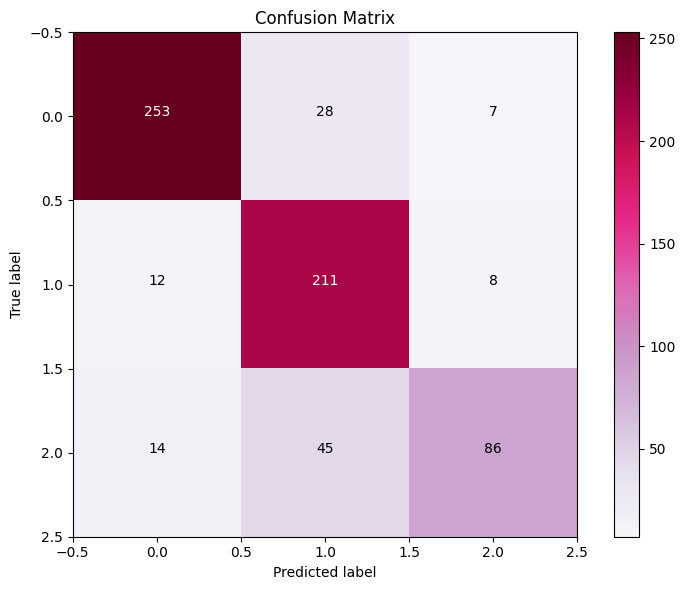

In [73]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_MLP.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()


**ROC_curve**

In [74]:
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

In [75]:
# y_train

In [76]:
# y_train = label_binarize(y_train,classes=[0,1])

In [77]:
# # Binarize the output
# y_train = label_binarize(y_train,classes=[0,1])
# n_classes = y_train.shape[1]
# print(n_classes)
# print(y_train)

In [78]:
# # Binarize the output (y_test)
# y_test = label_binarize(y_test,classes=[0,1])
# n_classes = y_test.shape[1]
# print(n_classes)
# print(y_test[0])

In [79]:
# # Learn to predict each class against the other
# from sklearn.neural_network import MLPClassifier

# ada_params = study.best_trial.params
# clf = MLPClassifier(**ada_params,tol=.00001,early_stopping=True) #tuned MLP
# classifier = OneVsRestClassifier(clf)

# # Train the classifier
# classifier.fit(compressed_dataset_X_train, y_train)

In [80]:
# # Compute ROC curve and ROC area for each class
# fpr = dict() #dictionary
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], classifier.predict_proba(compressed_dataset_X_test)[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

In [81]:
# # Plot ROC curve for each class
# plt.figure()
# for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], label='ROC curve for class(%i) (area = %0.2f)' % (i,roc_auc[i]))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="best")
# plt.show()